# Mixed data regression with Keras and CNNs
https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
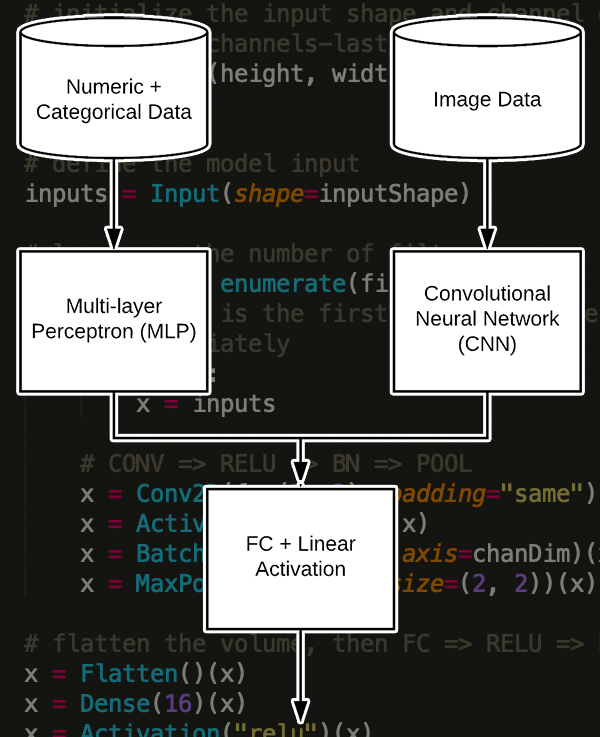

In [1]:
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
import pandas as pd
import numpy as np
import locale
import os
import glob
import cv2

Using TensorFlow backend.


## Settings

In [2]:
dataset = '../../datasets/Houses-dataset/Houses Dataset/'

## Function definition

In [3]:
def load_house_attributes(inputPath):
    # Initialize the list of column names in the CSV file and then load it using Pandas
    cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
    df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
    
    # Determine (1) the unique zip codes and (2) the number of data points with each zip code
    zipcodes = df["zipcode"].value_counts().keys().tolist()
    counts = df["zipcode"].value_counts().tolist()
    
    # Loop over each of the unique zip codes and their corresponding count
    for (zipcode, count) in zip(zipcodes, counts):
        # The zip code counts for our housing dataset is *extremely*
        # unbalanced (some only having 1 or 2 houses per zip code)
        # so let's sanitize our data by removing any houses with less
        # than 25 houses per zip code
        if count < 25:
            idxs = df[df["zipcode"] == zipcode].index
            df.drop(idxs, inplace=True)
            
    # Return the data frame
    return df

In [4]:
def process_house_attributes(df, train, test):
    # Initialize the column names of the continuous data
    continuous = ["bedrooms", "bathrooms", "area"]
    
    # Performin min-max scaling each continuous feature column to the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])
    
    # One-hot encode the zip code categorical data (by definition of
    # one-hot encoding, all output features are now in the range [0, 1])
    zipBinarizer = LabelBinarizer().fit(df["zipcode"])
    trainCategorical = zipBinarizer.transform(train["zipcode"])
    testCategorical = zipBinarizer.transform(test["zipcode"])
    
    # Construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])
    
    # Return the concatenated training and testing data
    return (trainX, testX)

In [5]:
def load_house_images(df, inputPath):
    # Initialize our images array (i.e., the house images themselves)
    images = []
    
    # Loop over the indexes of the houses
    for i in df.index.values:
        # Find the four images for the house and sort the file paths,
        # ensuring the four are always in the *same order*
        basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
        housePaths = sorted(list(glob.glob(basePath)))
        
        # Initialize our list of input images along with the output image
        # after *combining* the four input images
        inputImages = []
        outputImage = np.zeros((64, 64, 3), dtype="uint8")
        
        # Loop over the input house paths
        for housePath in housePaths:
            # Load the input image, resize it to be 32 32, and then update the list of input images
            image = cv2.imread(housePath)
            image = cv2.resize(image, (32, 32))
            inputImages.append(image)
            
        # Tile the four input images in the output image such the first
        # image goes in the top-right corner, the second image in the
        # top-left corner, the third image in the bottom-right corner,
        # and the final image in the bottom-left corner
        outputImage[0:32, 0:32] = inputImages[0]
        outputImage[0:32, 32:64] = inputImages[1]
        outputImage[32:64, 32:64] = inputImages[2]
        outputImage[32:64, 0:32] = inputImages[3]
        
        # Add the tiled image to our set of images the network will be trained on
        images.append(outputImage)
        
    # Return our set of images
    return np.array(images)

In [6]:
def create_mlp(dim, regress=False):
    # Define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    
    # Check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    
    # Return our model
    return model

In [7]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # Initialize the input shape and channel dimension, assuming TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    
    # Define the model input
    inputs = Input(shape=inputShape)

    # Loop over the number of filters
    for (i, f) in enumerate(filters):
        # If this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # Flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    
    # Apply another FC layer, this one to match the number of nodes coming out of the
    # Multilayer Perceptron (MLP)
    # Matching the number of nodes is not a requirement but it does help balance the branches.
    x = Dense(4)(x)
    x = Activation("relu")(x)
    
    # Check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    
    # Construct the CNN
    model = Model(inputs, x)
    
    # Return the CNN
    return model

## Training

In [8]:
# Construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
inputPath = os.path.sep.join([dataset, "HousesInfo.txt"])
df = load_house_attributes(inputPath)

# Load the house images and then scale the pixel intensities to the range [0, 1]
images = load_house_images(df, dataset)
images = images / 255.0

# Partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

In [9]:
# Find the largest house price in the training set and use it to scale our
# house prices to the range [0, 1] (will lead to better training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

# Process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

# Create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)

# Create the input to our final set of layers as the *output* of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# Our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# Our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [10]:
# Compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# Train the model
model.fit([trainAttrX, trainImagesX], trainY, validation_data=([testAttrX, testImagesX], testY), 
          epochs=200, batch_size=8)

Train on 271 samples, validate on 91 samples
Epoch 1/200
271/271 [==============================] - 1s 4ms/step - loss: 1815.0836 - val_loss: 132.6830
Epoch 2/200
271/271 [==============================] - 0s 2ms/step - loss: 849.7177 - val_loss: 326.0644
Epoch 3/200
271/271 [==============================] - 0s 2ms/step - loss: 451.3359 - val_loss: 396.4485
Epoch 4/200
271/271 [==============================] - 0s 2ms/step - loss: 356.3146 - val_loss: 474.7367
Epoch 5/200
271/271 [==============================] - 0s 2ms/step - loss: 232.5377 - val_loss: 536.3246
Epoch 6/200
271/271 [==============================] - 0s 2ms/step - loss: 205.4446 - val_loss: 452.5336
Epoch 7/200
271/271 [==============================] - 0s 2ms/step - loss: 216.4230 - val_loss: 448.0531
Epoch 8/200
271/271 [==============================] - 1s 2ms/step - loss: 168.2088 - val_loss: 435.0399
Epoch 9/200
271/271 [==============================] - 1s 2ms/step - loss: 151.5216 - val_loss: 512.2187
Epoch 10/

271/271 [==============================] - 1s 2ms/step - loss: 21.0716 - val_loss: 22.9511
Epoch 80/200
271/271 [==============================] - 1s 2ms/step - loss: 21.4455 - val_loss: 22.5929
Epoch 81/200
271/271 [==============================] - 1s 2ms/step - loss: 22.4936 - val_loss: 23.3774
Epoch 82/200
271/271 [==============================] - 1s 2ms/step - loss: 21.0796 - val_loss: 22.7203
Epoch 83/200
271/271 [==============================] - 1s 2ms/step - loss: 21.1809 - val_loss: 22.1878
Epoch 84/200
271/271 [==============================] - 1s 2ms/step - loss: 21.4000 - val_loss: 22.4054
Epoch 85/200
271/271 [==============================] - 1s 2ms/step - loss: 22.6947 - val_loss: 24.6870
Epoch 86/200
271/271 [==============================] - 1s 2ms/step - loss: 21.4673 - val_loss: 22.5690
Epoch 87/200
271/271 [==============================] - 1s 2ms/step - loss: 21.2661 - val_loss: 23.5023
Epoch 88/200
271/271 [==============================] - 1s 2ms/step - loss: 2

271/271 [==============================] - 1s 2ms/step - loss: 18.3744 - val_loss: 27.4228
Epoch 158/200
271/271 [==============================] - 0s 2ms/step - loss: 18.9859 - val_loss: 23.0119
Epoch 159/200
271/271 [==============================] - 1s 2ms/step - loss: 19.2020 - val_loss: 24.3125
Epoch 160/200
271/271 [==============================] - 0s 2ms/step - loss: 20.4224 - val_loss: 22.9738
Epoch 161/200
271/271 [==============================] - 0s 2ms/step - loss: 18.2708 - val_loss: 24.4352
Epoch 162/200
271/271 [==============================] - 0s 2ms/step - loss: 19.4706 - val_loss: 22.7194
Epoch 163/200
271/271 [==============================] - 1s 2ms/step - loss: 18.9852 - val_loss: 22.8903
Epoch 164/200
271/271 [==============================] - 1s 2ms/step - loss: 18.3495 - val_loss: 21.8438
Epoch 165/200
271/271 [==============================] - 1s 2ms/step - loss: 19.3198 - val_loss: 22.8946
Epoch 166/200
271/271 [==============================] - 1s 2ms/step 

## Evaluation

In [11]:
# Make predictions on the testing data
preds = model.predict([testAttrX, testImagesX])

# Compute the difference between the *predicted* house prices and the *actual* house prices,
# then compute the percentage difference and the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# Compute the mean and standard deviation of the absolute percentage difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# Finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("Avg. house price: {}, std house price: {}".format(locale.currency(df["price"].mean(), grouping=True),
                                                         locale.currency(df["price"].std(), grouping=True)))
print("Mean: {:.2f}%, std: {:.2f}%".format(mean, std))

Avg. house price: $533,388.27, std house price: $493,403.08
Mean: 22.94%, std: 20.75%
